# Bandit strategy comparison
This notebook builds a configurable Gaussian N-armed testbed and compares epsilon-greedy, optimistic initialization, and UCB.


## 1) Imports and shared data structures
We start with imports and a small dataclass used to hold strategy settings.


In [1]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np


@dataclass(frozen=True)
class StrategyConfig:
    """Configuration for one action-selection strategy."""

    name: str
    epsilon: float
    optimistic_initial: float
    ucb_c: float | None = None


## 2) Experiment configuration variables
These variables replace CLI args so you can tune the experiment directly in the notebook.


In [2]:
# Configurable experiment settings
ARMS = 10
RUNS = 2000
STEPS = 1000
EPSILON = 0.1
OPTIMISTIC_INITIAL = 5.0
UCB_C = 2.0
SEED = 42
SAVE_PLOT = Path('src') / 'learning_curves.png'

if ARMS < 2:
    raise ValueError('ARMS must be at least 2.')
if RUNS < 1:
    raise ValueError('RUNS must be at least 1.')
if STEPS < 1:
    raise ValueError('STEPS must be at least 1.')
if not 0.0 <= EPSILON <= 1.0:
    raise ValueError('EPSILON must be between 0 and 1.')
if UCB_C <= 0:
    raise ValueError('UCB_C must be greater than 0.')


## 3) Action selection and per-run simulation
This section defines how each strategy picks actions and updates value estimates from Gaussian rewards.


In [3]:
def select_action(
    estimates: np.ndarray,
    counts: np.ndarray,
    step: int,
    config: StrategyConfig,
    rng: np.random.Generator,
) -> int:
    """Select an action under epsilon-greedy or UCB behavior."""
    if config.ucb_c is not None:
        untried = np.where(counts == 0)[0]
        if untried.size > 0:
            return int(untried[0])
        bonus = config.ucb_c * np.sqrt(np.log(step + 1) / counts)
        values = estimates + bonus
    else:
        values = estimates

    if rng.random() < config.epsilon:
        return int(rng.integers(len(estimates)))

    best_actions = np.flatnonzero(values == values.max())
    return int(rng.choice(best_actions))


def run_strategy(
    q_true: np.ndarray,
    config: StrategyConfig,
    steps: int,
    rng: np.random.Generator,
) -> Tuple[np.ndarray, np.ndarray]:
    """Run one strategy on one testbed instance and return traces."""
    arms = q_true.size
    estimates = np.full(arms, config.optimistic_initial, dtype=float)
    counts = np.zeros(arms, dtype=float)
    rewards = np.zeros(steps, dtype=float)
    optimal_hits = np.zeros(steps, dtype=float)
    optimal_action = int(np.argmax(q_true))

    for step in range(steps):
        action = select_action(estimates, counts, step, config, rng)
        reward = rng.normal(loc=q_true[action], scale=1.0)
        counts[action] += 1.0
        estimates[action] += (reward - estimates[action]) / counts[action]
        rewards[step] = reward
        optimal_hits[step] = float(action == optimal_action)

    return rewards, optimal_hits


## 4) Multi-run experiment and plotting
Aggregate results across runs to produce learning curves and final-step summary metrics.


In [4]:
def run_experiment(
    arms: int,
    runs: int,
    steps: int,
    strategies: List[StrategyConfig],
    seed: int,
) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
    """Simulate all strategies and aggregate average learning curves."""
    rng = np.random.default_rng(seed)
    results: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}

    for strategy in strategies:
        reward_sum = np.zeros(steps, dtype=float)
        optimal_sum = np.zeros(steps, dtype=float)
        for _ in range(runs):
            q_true = rng.normal(loc=0.0, scale=1.0, size=arms)
            rewards, optimal_hits = run_strategy(q_true, strategy, steps, rng)
            reward_sum += rewards
            optimal_sum += optimal_hits
        results[strategy.name] = (reward_sum / runs, optimal_sum / runs)

    return results


def plot_results(
    results: Dict[str, Tuple[np.ndarray, np.ndarray]],
    output_path: Path,
) -> None:
    """Plot average reward and optimal-action curves for each strategy."""
    output_path.parent.mkdir(parents=True, exist_ok=True)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), constrained_layout=True)

    for name, (avg_reward, optimal_rate) in results.items():
        axes[0].plot(avg_reward, label=name)
        axes[1].plot(optimal_rate * 100.0, label=name)

    axes[0].set_title('Average reward')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Reward')

    axes[1].set_title('% optimal action')
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Optimal action (%)')

    for axis in axes:
        axis.grid(alpha=0.25)
        axis.legend()

    fig.savefig(output_path, dpi=150)
    plt.show()


def print_summary(results: Dict[str, Tuple[np.ndarray, np.ndarray]]) -> None:
    """Print final-step metrics to complement the learning-curve plot."""
    print('Final-step performance:')
    for name, (avg_reward, optimal_rate) in results.items():
        reward = avg_reward[-1]
        optimal_pct = optimal_rate[-1] * 100.0
        print(f'- {name}: reward={reward:.3f}, optimal_action={optimal_pct:.1f}%')


## 5) Execute the comparison
Run this cell after editing configuration variables to compare the three strategies on the selected number of arms.


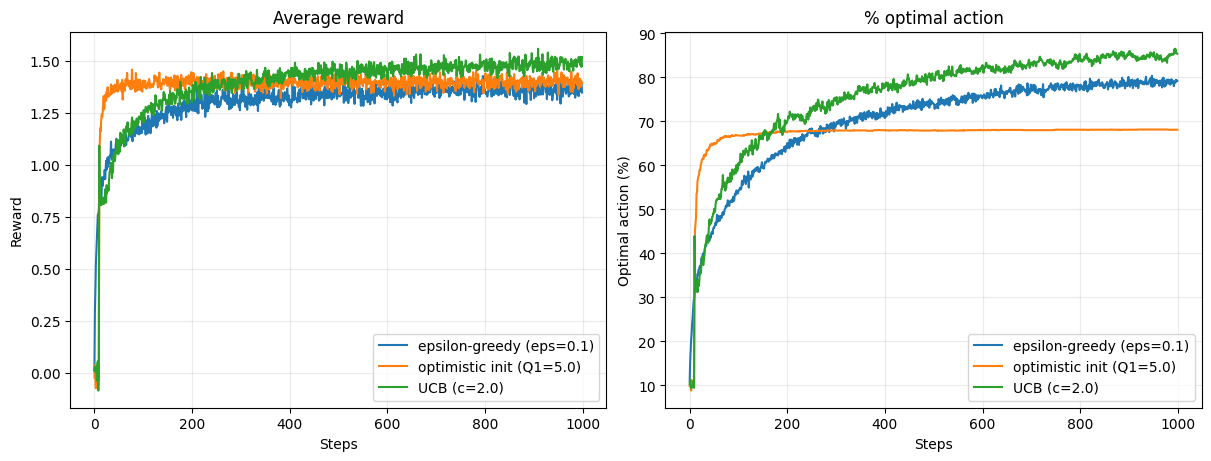

Final-step performance:
- epsilon-greedy (eps=0.1): reward=1.349, optimal_action=79.2%
- optimistic init (Q1=5.0): reward=1.395, optimal_action=68.1%
- UCB (c=2.0): reward=1.520, optimal_action=85.4%
Saved learning-curve plot to: src\learning_curves.png


In [5]:
strategies = [
    StrategyConfig(
        name=f'epsilon-greedy (eps={EPSILON})',
        epsilon=EPSILON,
        optimistic_initial=0.0,
    ),
    StrategyConfig(
        name=f'optimistic init (Q1={OPTIMISTIC_INITIAL})',
        epsilon=0.0,
        optimistic_initial=OPTIMISTIC_INITIAL,
    ),
    StrategyConfig(
        name=f'UCB (c={UCB_C})',
        epsilon=0.0,
        optimistic_initial=0.0,
        ucb_c=UCB_C,
    ),
]

results = run_experiment(
    arms=ARMS,
    runs=RUNS,
    steps=STEPS,
    strategies=strategies,
    seed=SEED,
)
plot_results(results, SAVE_PLOT)
print_summary(results)
print(f'Saved learning-curve plot to: {SAVE_PLOT}')
